# Lab 3: Contextual Bandit-Based News Article Recommendation

**`Course`:** Reinforcement Learning Fundamentals  
**`Student Name`: Rishit**  
**`Roll Number`: U20230024**  
**`GitHub Branch`: rishit_U20230024**  

# Imports and Setup

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from rlcmab_sampler import sampler
import warnings
warnings.filterwarnings('ignore')

np.random.seed(24)

#plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Spectral")

# Load Datasets

In [21]:
news_df = pd.read_csv("data/news_articles.csv")
train_users = pd.read_csv("data/train_users.csv")
test_users = pd.read_csv("data/test_users.csv")
print("News Articles Dataset Shape:", news_df.shape)
print("Train Users Dataset Shape:", train_users.shape)
print("Test Users Dataset Shape:", test_users.shape)
print("\nNews Categories:")
print(news_df['category'].value_counts())
print("\nTrain User Categories:")
print(train_users['label'].value_counts())

News Articles Dataset Shape: (209527, 6)
Train Users Dataset Shape: (2000, 33)
Test Users Dataset Shape: (2000, 32)

News Categories:
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS        

## Data Preprocessing

In this section:
- Handle missing values
- Encode categorical features
- Prepare data for user classification

In [22]:
#missing values
print("Missing values in news_df:")
print(news_df.isnull().sum())
print("\nMissing values in train_users:")
print(train_users.isnull().sum())
print("\nMissing values in test_users:")
print(test_users.isnull().sum())

#clean news
news_df_clean = news_df.dropna(subset=['category', 'headline']).reset_index(drop=True)

#map to 4 cats
category_mapping = {
    'ENTERTAINMENT': 'Entertainment',
    'COMEDY': 'Entertainment',
    'PARENTING': 'Entertainment',
    'EDUCATION': 'Education',
    'COLLEGE': 'Education',
    'TECH': 'Tech',
    'SCIENCE': 'Tech',
    'CRIME': 'Crime',
    'POLITICS': 'Crime',
    'WORLD NEWS': 'Crime',
    'U.S. NEWS': 'Crime',
    'WORLDPOST': 'Crime'
}

news_df_clean['category'] = news_df_clean['category'].map(
    lambda x: category_mapping.get(x, 'Entertainment')
)

valid_categories = ['Entertainment', 'Education', 'Tech', 'Crime']
news_df_clean = news_df_clean[news_df_clean['category'].isin(valid_categories)]

print(f"\nCleaned News Articles: {news_df_clean.shape}")
print("\nNews Category Distribution:")
print(news_df_clean['category'].value_counts())

#clean user data
train_users_clean = train_users.copy()
test_users_clean = test_users.copy()

#imputation
age_median = train_users_clean['age'].median()
train_users_clean['age'].fillna(age_median, inplace=True)
test_users_clean['age'].fillna(age_median, inplace=True)

#encoding
all_region_codes = pd.concat([train_users_clean['region_code'], 
                               test_users_clean['region_code']]).unique()
le_region = LabelEncoder()
le_region.fit(all_region_codes)

train_users_clean['region_code_encoded'] = le_region.transform(train_users_clean['region_code'])
test_users_clean['region_code_encoded'] = le_region.transform(test_users_clean['region_code'])

train_users_clean['subscriber_encoded'] = train_users_clean['subscriber'].astype(int)
test_users_clean['subscriber_encoded'] = test_users_clean['subscriber'].astype(int)

#label encoding
le_user = LabelEncoder()
train_users_clean['label_encoded'] = le_user.fit_transform(train_users_clean['label'])

print(f"\nCleaned Train Users: {train_users_clean.shape}")
print(f"Cleaned Test Users: {test_users_clean.shape}")
print("\nUser Label Mapping:")
for i, label in enumerate(le_user.classes_):
    print(f"{i}: {label}")

Missing values in news_df:
link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64

Missing values in train_users:
user_id                          0
age                            698
income                           0
clicks                           0
purchase_amount                  0
session_duration                 0
content_variety                  0
engagement_score                 0
num_transactions                 0
avg_monthly_spend                0
avg_cart_value                   0
browsing_depth                   0
revisit_rate                     0
scroll_activity                  0
time_on_site                     0
interaction_count                0
preferred_price_range            0
discount_usage_rate              0
wishlist_size                    0
product_views                    0
repeat_purchase_gap (days)       0
churn_risk_score               

## User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`),
which serves as the **context** for the contextual bandit.


In [23]:
#feature columns for classification
exclude_cols = ['user_id', 'region_code', 'subscriber', 'label', 'browser_version']
feature_cols = [col for col in train_users_clean.columns 
                if col not in exclude_cols and col not in ['label_encoded', 'region_code_encoded', 'subscriber_encoded']]

feature_cols.extend(['region_code_encoded', 'subscriber_encoded'])

print(f"Number of features: {len(feature_cols)}")
print(f"\nFeatures used for classification:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i}. {col}")

#feature + target train test split
X = train_users_clean[feature_cols]
y = train_users_clean['label_encoded']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

Number of features: 30

Features used for classification:
1. age
2. income
3. clicks
4. purchase_amount
5. session_duration
6. content_variety
7. engagement_score
8. num_transactions
9. avg_monthly_spend
10. avg_cart_value
11. browsing_depth
12. revisit_rate
13. scroll_activity
14. time_on_site
15. interaction_count
16. preferred_price_range
17. discount_usage_rate
18. wishlist_size
19. product_views
20. repeat_purchase_gap (days)
21. churn_risk_score
22. loyalty_index
23. screen_brightness
24. battery_percentage
25. cart_abandonment_count
26. background_app_count
27. session_inactivity_duration
28. network_jitter
29. region_code_encoded
30. subscriber_encoded

Training set size: (1600, 30)
Validation set size: (400, 30)


In [24]:
#train dt + pred + eval
dt_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_classifier.fit(X_train, y_train)

y_train_pred = dt_classifier.predict(X_train)
y_val_pred = dt_classifier.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

print(classification_report(y_val, y_val_pred, target_names=le_user.classes_))


Training Accuracy: 0.9375
Validation Accuracy: 0.8725
              precision    recall  f1-score   support

      user_1       0.86      0.82      0.84       142
      user_2       0.95      0.87      0.91       142
      user_3       0.81      0.95      0.87       116

    accuracy                           0.87       400
   macro avg       0.87      0.88      0.87       400
weighted avg       0.88      0.87      0.87       400



# `Contextual Bandit`

## Reward Sampler Initialization

The sampler is initialized using the student's roll number `i`.
Rewards are obtained using `sampler.sample(j)`.


## Arm Mapping

| Arm Index (j) | News Category | User Context |
|--------------|---------------|--------------|
| 0–3          | Entertainment, Education, Tech, Crime | User1 |
| 4–7          | Entertainment, Education, Tech, Crime | User2 |
| 8–11         | Entertainment, Education, Tech, Crime | User3 |

In [25]:
# arm mapping

def get_arm_index(user_context_idx, news_category):
    """
    Convert user context and news category to arm index j (0-11)
    
    user_context_idx: 0 (user_1), 1 (user_2), 2 (user_3)
    news_category: 'Entertainment', 'Education', 'Tech', 'Crime'
    """
    category_to_idx = {
        'Entertainment': 0,
        'Education': 1,
        'Tech': 2,
        'Crime': 3
    }
    
    category_idx = category_to_idx[news_category]
    arm_idx = user_context_idx * 4 + category_idx
    return arm_idx

def get_category_from_arm(arm_idx):
    """Convert arm index back to (user_context, category)"""
    user_context_idx = arm_idx // 4
    category_idx = arm_idx % 4
    
    idx_to_category = {0: 'Entertainment', 1: 'Education', 2: 'Tech', 3: 'Crime'}
    idx_to_user = {0: 'user_1', 1: 'user_2', 2: 'user_3'}
    
    return idx_to_user[user_context_idx], idx_to_category[category_idx]

print("Arm Index Mapping Test:")
for j in range(12):
    user, cat = get_category_from_arm(j)
    print(f"Arm {j}: ({cat}, {user})")

Arm Index Mapping Test:
Arm 0: (Entertainment, user_1)
Arm 1: (Education, user_1)
Arm 2: (Tech, user_1)
Arm 3: (Crime, user_1)
Arm 4: (Entertainment, user_2)
Arm 5: (Education, user_2)
Arm 6: (Tech, user_2)
Arm 7: (Crime, user_2)
Arm 8: (Entertainment, user_3)
Arm 9: (Education, user_3)
Arm 10: (Tech, user_3)
Arm 11: (Crime, user_3)


In [26]:
ROLL_NUMBER = 24
reward_sampler = sampler(ROLL_NUMBER)

print("\narm test samples:")
for j in range(12):
    user, cat = get_category_from_arm(j)
    test_reward = reward_sampler.sample(j)
    print(f"Arm {j} ({cat}, {user}): {test_reward:.4f}")


arm test samples:
Arm 0 (Entertainment, user_1): 2.7567
Arm 1 (Education, user_1): -6.3318
Arm 2 (Tech, user_1): 2.0494
Arm 3 (Crime, user_1): -5.5854
Arm 4 (Entertainment, user_2): 4.1190
Arm 5 (Education, user_2): -4.9650
Arm 6 (Tech, user_2): -1.3342
Arm 7 (Crime, user_2): -1.5110
Arm 8 (Entertainment, user_3): -2.5214
Arm 9 (Education, user_3): 5.0289
Arm 10 (Tech, user_3): 7.3663
Arm 11 (Crime, user_3): 11.1195


## Epsilon-Greedy Strategy

This section implements the epsilon-greedy contextual bandit algorithm.


In [27]:
class EpsilonGreedy:
    def __init__(self, n_arms, epsilon, sampler):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.sampler = sampler
        self.counts = np.zeros(n_arms)  
        self.values = np.zeros(n_arms)  
        self.rewards_history = []
        
    def select_arm(self, context_arms):
        """
        Select an arm given valid arms for the current context
        context_arms: list of valid arm indices for current context
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(context_arms)
        else:
            context_values = [self.values[arm] for arm in context_arms]
            best_idx = np.argmax(context_values)
            return context_arms[best_idx]
    
    def update(self, arm, reward):
        """Update arm statistics"""
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = value + (reward - value) / n
        self.rewards_history.append(reward)
    
    def run_simulation(self, T, context_distribution):
        """
        Run simulation for T steps
        context_distribution: dict mapping context_idx to probability
        """
        cumulative_rewards = []
        total_reward = 0
        
        for t in range(T):
            context_idx = np.random.choice(
                list(context_distribution.keys()),
                p=list(context_distribution.values())
            )
            
            context_arms = list(range(context_idx * 4, (context_idx + 1) * 4))
            
            chosen_arm = self.select_arm(context_arms)
            
            reward = self.sampler.sample(chosen_arm)
            
            self.update(chosen_arm, reward)
            total_reward += reward
            cumulative_rewards.append(total_reward / (t + 1))
        
        return cumulative_rewards

print("Defined Epsilon-Greedy")

Defined Epsilon-Greedy


## Upper Confidence Bound (UCB)

This section implements the UCB strategy for contextual bandits.

In [28]:
class UCB:
    def __init__(self, n_arms, c, sampler):
        self.n_arms = n_arms
        self.c = c  
        self.sampler = sampler
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.rewards_history = []
        self.total_counts = 0
        
    def select_arm(self, context_arms):
        """Select arm using UCB strategy"""
        for arm in context_arms:
            if self.counts[arm] == 0:
                return arm
        
        ucb_values = []
        for arm in context_arms:
            avg_reward = self.values[arm]
            exploration_bonus = self.c * np.sqrt(
                np.log(self.total_counts + 1) / self.counts[arm]
            )
            ucb_values.append(avg_reward + exploration_bonus)
        
        best_idx = np.argmax(ucb_values)
        return context_arms[best_idx]
    
    def update(self, arm, reward):
        """Update arm statistics"""
        self.counts[arm] += 1
        self.total_counts += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = value + (reward - value) / n
        self.rewards_history.append(reward)
    
    def run_simulation(self, T, context_distribution):
        """Run simulation for T steps"""
        cumulative_rewards = []
        total_reward = 0
        
        for t in range(T):
            context_idx = np.random.choice(
                list(context_distribution.keys()),
                p=list(context_distribution.values())
            )
            
            context_arms = list(range(context_idx * 4, (context_idx + 1) * 4))
            
            chosen_arm = self.select_arm(context_arms)
            
            reward = self.sampler.sample(chosen_arm)
            
            self.update(chosen_arm, reward)
            total_reward += reward
            cumulative_rewards.append(total_reward / (t + 1))
        
        return cumulative_rewards

print("Defined UCB")

Defined UCB


## SoftMax Strategy

This section implements the SoftMax strategy with temperature $ \tau = 1$.


In [29]:
class SoftMax:
    def __init__(self, n_arms, tau, sampler):
        self.n_arms = n_arms
        self.tau = tau
        self.sampler = sampler
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.rewards_history = []
        
    def select_arm(self, context_arms):
        """Select arm using SoftMax (Boltzmann) exploration"""
        context_values = np.array([self.values[arm] for arm in context_arms])
        
        exp_values = np.exp(context_values / self.tau)
        probabilities = exp_values / np.sum(exp_values)
        
        chosen_idx = np.random.choice(len(context_arms), p=probabilities)
        return context_arms[chosen_idx]
    
    def update(self, arm, reward):
        """Update arm statistics"""
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = value + (reward - value) / n
        self.rewards_history.append(reward)
    
    def run_simulation(self, T, context_distribution):
        """Run simulation for T steps"""
        cumulative_rewards = []
        total_reward = 0
        
        for t in range(T):
            context_idx = np.random.choice(
                list(context_distribution.keys()),
                p=list(context_distribution.values())
            )
            
            context_arms = list(range(context_idx * 4, (context_idx + 1) * 4))
            
            chosen_arm = self.select_arm(context_arms)
            
            reward = self.sampler.sample(chosen_arm)
            
            self.update(chosen_arm, reward)
            total_reward += reward
            cumulative_rewards.append(total_reward / (t + 1))
        
        return cumulative_rewards

print("Defined SoftMax")

Defined SoftMax


## Reinforcement Learning Simulation

We simulate the bandit algorithms for $T = 10,000$ steps and record rewards.


In [30]:
#params
T = 10000 
n_arms = 12 

context_distribution = {0: 1/3, 1: 1/3, 2: 1/3}
epsilon_values = [0.01, 0.1, 0.3]
eg_results = {}

for eps in epsilon_values:
    eg = EpsilonGreedy(n_arms, eps, reward_sampler)
    cumulative_rewards = eg.run_simulation(T, context_distribution)
    eg_results[eps] = {
        'cumulative_rewards': cumulative_rewards,
        'model': eg
    }

c_values = [0.5, 1.0, 2.0]
ucb_results = {}

for c in c_values:
    ucb = UCB(n_arms, c, reward_sampler)
    cumulative_rewards = ucb.run_simulation(T, context_distribution)
    ucb_results[c] = {
        'cumulative_rewards': cumulative_rewards,
        'model': ucb
    }

tau = 1.0
softmax = SoftMax(n_arms, tau, reward_sampler)
softmax_cumulative_rewards = softmax.run_simulation(T, context_distribution)

print("\nSimulations completed.")


Simulations completed.


## Results and Analysis

This section presents:
- Average Reward vs Time
- Hyperparameter comparisons
- Observations and discussion


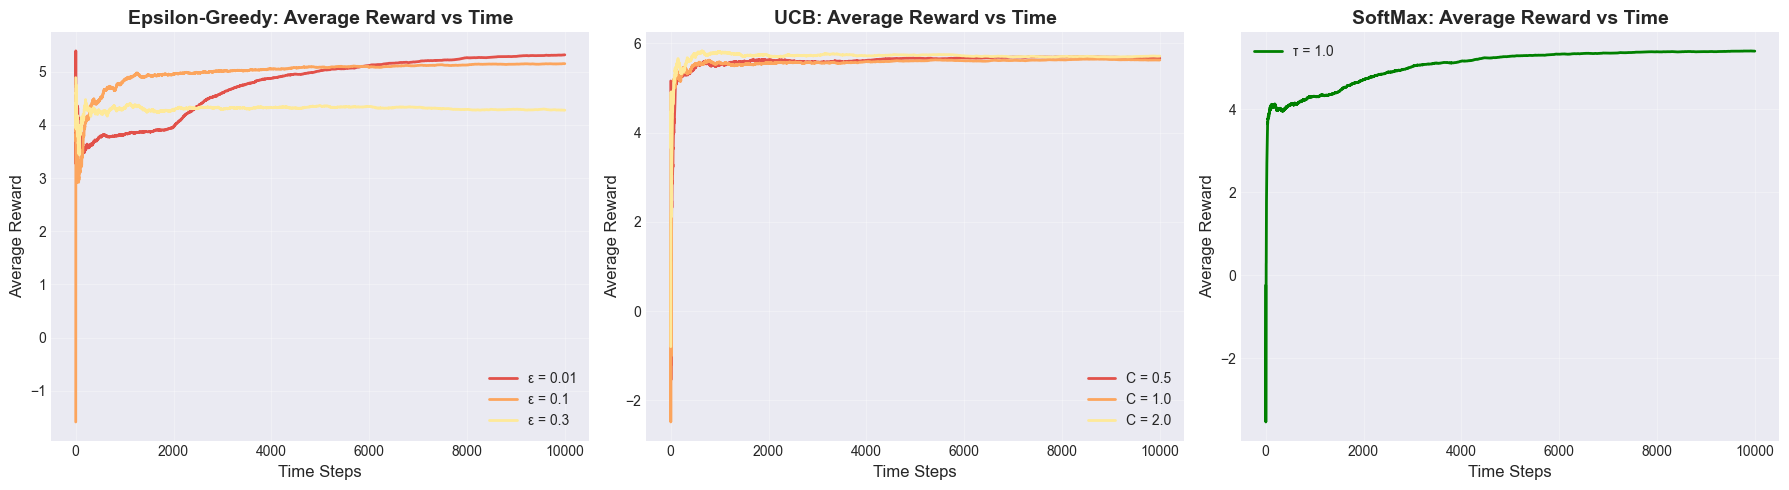

In [31]:
#plot comparisons
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#eg
ax = axes[0]
for eps in epsilon_values:
    rewards = eg_results[eps]['cumulative_rewards']
    ax.plot(rewards, label=f'ε = {eps}', linewidth=2)
ax.set_xlabel('Time Steps', fontsize=12)
ax.set_ylabel('Average Reward', fontsize=12)
ax.set_title('Epsilon-Greedy: Average Reward vs Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

#ucb
ax = axes[1]
for c in c_values:
    rewards = ucb_results[c]['cumulative_rewards']
    ax.plot(rewards, label=f'C = {c}', linewidth=2)
ax.set_xlabel('Time Steps', fontsize=12)
ax.set_ylabel('Average Reward', fontsize=12)
ax.set_title('UCB: Average Reward vs Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

#sm
ax = axes[2]
ax.plot(softmax_cumulative_rewards, label=f'τ = {tau}', linewidth=2, color='green')
ax.set_xlabel('Time Steps', fontsize=12)
ax.set_ylabel('Average Reward', fontsize=12)
ax.set_title('SoftMax: Average Reward vs Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('avg_reward_vs_time.png', dpi=300, bbox_inches='tight')
plt.show()


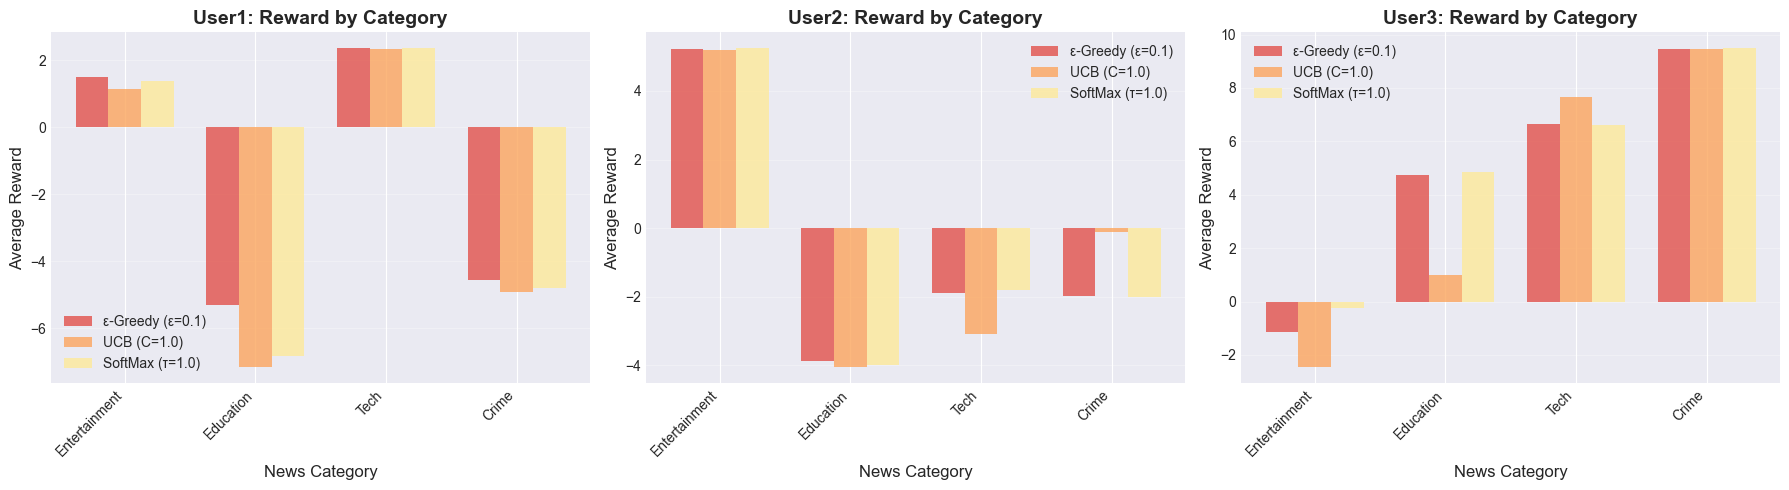

In [32]:
#analyse perf
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

context_names = ['User1', 'User2', 'User3']
categories = ['Entertainment', 'Education', 'Tech', 'Crime']

for ctx_idx, ax in enumerate(axes):
    context_arms = range(ctx_idx * 4, (ctx_idx + 1) * 4)
    
    #eg on best epsilon
    best_eps = 0.1
    eg_values = [eg_results[best_eps]['model'].values[arm] for arm in context_arms]
    
    #ucb on best c
    best_c = 1.0
    ucb_values = [ucb_results[best_c]['model'].values[arm] for arm in context_arms]
    
    #sm
    softmax_values = [softmax.values[arm] for arm in context_arms]
    
    x = np.arange(len(categories))
    width = 0.25
    
    ax.bar(x - width, eg_values, width, label=f'ε-Greedy (ε={best_eps})', alpha=0.8)
    ax.bar(x, ucb_values, width, label=f'UCB (C={best_c})', alpha=0.8)
    ax.bar(x + width, softmax_values, width, label=f'SoftMax (τ={tau})', alpha=0.8)
    
    ax.set_xlabel('News Category', fontsize=12)
    ax.set_ylabel('Average Reward', fontsize=12)
    ax.set_title(f'{context_names[ctx_idx]}: Reward by Category', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('reward_by_context.png', dpi=300, bbox_inches='tight')
plt.show()

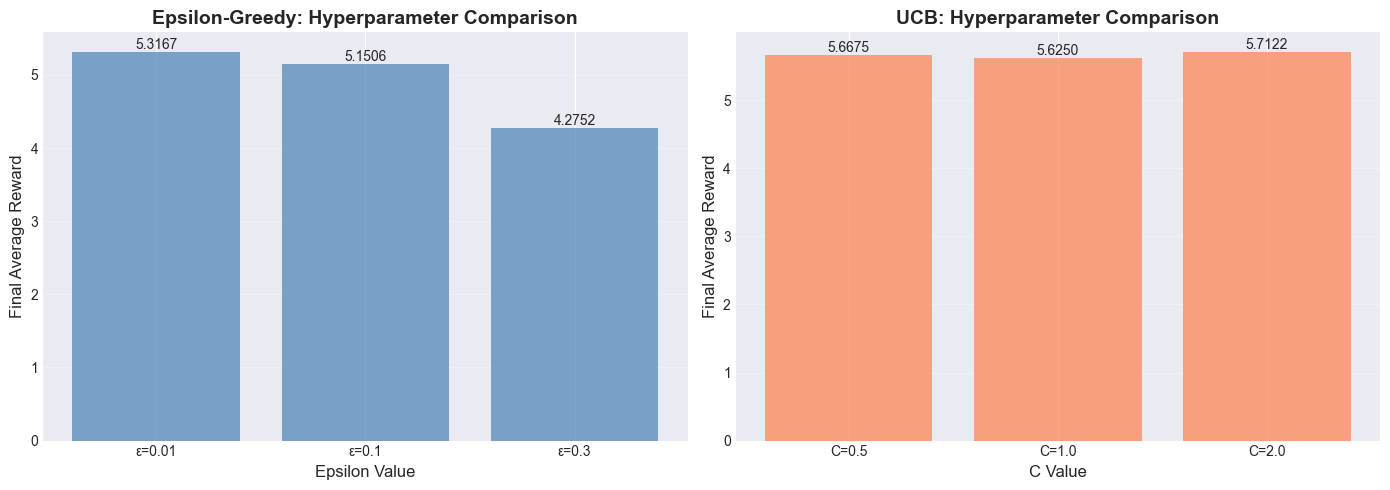

In [33]:
#compare for diff hyperparameters
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#eg
ax = axes[0]
final_rewards_eps = [eg_results[eps]['cumulative_rewards'][-1] for eps in epsilon_values]
bars = ax.bar([f'ε={eps}' for eps in epsilon_values], final_rewards_eps, color='steelblue', alpha=0.7)
ax.set_xlabel('Epsilon Value', fontsize=12)
ax.set_ylabel('Final Average Reward', fontsize=12)
ax.set_title('Epsilon-Greedy: Hyperparameter Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

#ucb
ax = axes[1]
final_rewards_c = [ucb_results[c]['cumulative_rewards'][-1] for c in c_values]
bars = ax.bar([f'C={c}' for c in c_values], final_rewards_c, color='coral', alpha=0.7)
ax.set_xlabel('C Value', fontsize=12)
ax.set_ylabel('Final Average Reward', fontsize=12)
ax.set_title('UCB: Hyperparameter Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('hyperparameter_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

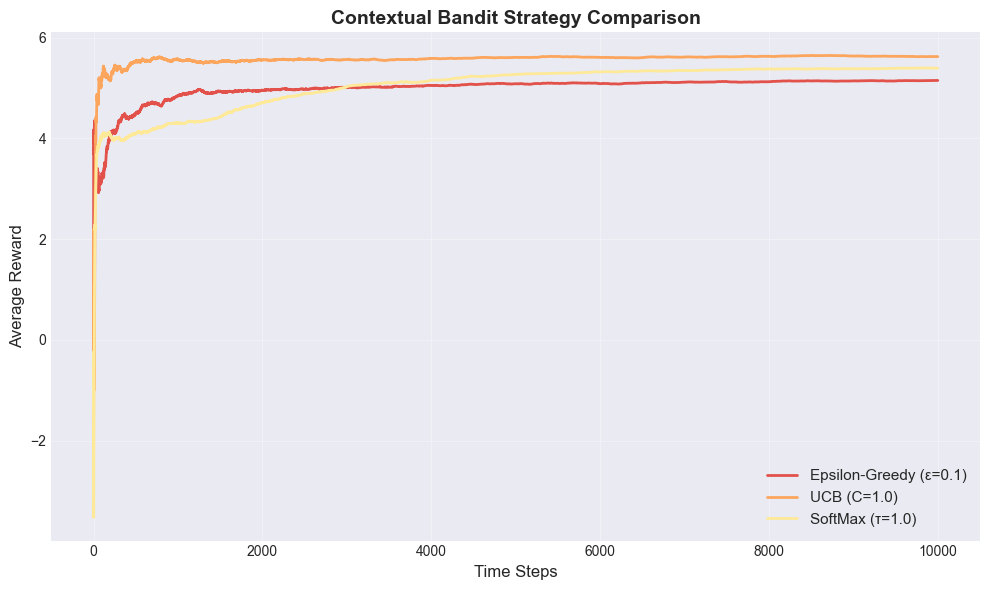

Performance Comparison

Epsilon-Greedy (ε=0.1):
  Final Average Reward: 5.1506

UCB (C=1.0):
  Final Average Reward: 5.6250

SoftMax (τ=1.0):
  Final Average Reward: 5.3954


In [34]:
#compare strats
fig, ax = plt.subplots(figsize=(10, 6))

best_eps = 0.1
best_c = 1.0

ax.plot(eg_results[best_eps]['cumulative_rewards'], 
        label=f'Epsilon-Greedy (ε={best_eps})', linewidth=2)
ax.plot(ucb_results[best_c]['cumulative_rewards'], 
        label=f'UCB (C={best_c})', linewidth=2)
ax.plot(softmax_cumulative_rewards, 
        label=f'SoftMax (τ={tau})', linewidth=2)

ax.set_xlabel('Time Steps', fontsize=12)
ax.set_ylabel('Average Reward', fontsize=12)
ax.set_title('Contextual Bandit Strategy Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('strategy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

#final stats
print("Performance Comparison")
print(f"\nEpsilon-Greedy (ε={best_eps}):")
print(f"  Final Average Reward: {eg_results[best_eps]['cumulative_rewards'][-1]:.4f}")

print(f"\nUCB (C={best_c}):")
print(f"  Final Average Reward: {ucb_results[best_c]['cumulative_rewards'][-1]:.4f}")

print(f"\nSoftMax (τ={tau}):")
print(f"  Final Average Reward: {softmax_cumulative_rewards[-1]:.4f}")

In [35]:
class NewsRecommendationSystem:
    def __init__(self, classifier, bandit_model, news_df, le_user, feature_cols):
        self.classifier = classifier
        self.bandit_model = bandit_model
        self.news_df = news_df
        self.le_user = le_user
        self.feature_cols = feature_cols
        
    def recommend(self, user_features):
        user_context = self.classifier.predict(user_features[self.feature_cols].values.reshape(1, -1))[0]
        user_label = self.le_user.inverse_transform([user_context])[0]
        
        context_arms = list(range(user_context * 4, (user_context + 1) * 4))
        
        arm_values = [self.bandit_model.values[arm] for arm in context_arms]
        best_arm_idx = np.argmax(arm_values)
        best_arm = context_arms[best_arm_idx]
        
        _, category = get_category_from_arm(best_arm)

        category_articles = self.news_df[self.news_df['category'] == category]
        
        if len(category_articles) > 0:
            recommended_article = category_articles.sample(1).iloc[0]
        else:
            recommended_article = None
        
        return {
            'user_context': user_label,
            'recommended_category': category,
            'arm_index': best_arm,
            'expected_reward': self.bandit_model.values[best_arm],
            'article': recommended_article
        }

best_eg_eps = max(epsilon_values, key=lambda eps: eg_results[eps]['cumulative_rewards'][-1])
best_ucb_c = max(c_values, key=lambda c: ucb_results[c]['cumulative_rewards'][-1])

best_eg_reward = eg_results[best_eg_eps]['cumulative_rewards'][-1]
best_ucb_reward = ucb_results[best_ucb_c]['cumulative_rewards'][-1]
best_softmax_reward = softmax_cumulative_rewards[-1]

strategies = {
    'Epsilon-Greedy': (best_eg_reward, eg_results[best_eg_eps]['model'], f'ε={best_eg_eps}'),
    'UCB': (best_ucb_reward, ucb_results[best_ucb_c]['model'], f'C={best_ucb_c}'),
    'SoftMax': (best_softmax_reward, softmax, f'τ={tau}')
}

best_strategy_name = max(strategies, key=lambda k: strategies[k][0])
best_reward, best_model, best_params = strategies[best_strategy_name]

print("Model Selection")
print(f"\nEpsilon-Greedy (ε={best_eg_eps}): {best_eg_reward:.4f}")
print(f"UCB (C={best_ucb_c}): {best_ucb_reward:.4f}")
print(f"SoftMax (τ={tau}): {best_softmax_reward:.4f}")
print(f"\nFinal Model: {best_strategy_name} with {best_params}")
print(f"Final Average Reward: {best_reward:.4f}")

#init rec with best model
recommendation_system = NewsRecommendationSystem(
    classifier=dt_classifier,
    bandit_model=best_model,
    news_df=news_df_clean,
    le_user=le_user,
    feature_cols=feature_cols
)

print(f"News recommendation system initialized with {best_strategy_name}.")

Model Selection

Epsilon-Greedy (ε=0.01): 5.3167
UCB (C=2.0): 5.7122
SoftMax (τ=1.0): 5.3954

Final Model: UCB with C=2.0
Final Average Reward: 5.7122
News recommendation system initialized with UCB.


In [36]:
#recs for all users
all_recommendations = []

for idx in range(len(test_users_clean)):
    user = test_users_clean.iloc[idx]
    recommendation = recommendation_system.recommend(user)
    
    all_recommendations.append({
        'user_id': user['user_id'],
        'predicted_context': recommendation['user_context'],
        'recommended_category': recommendation['recommended_category'],
        'arm_index': recommendation['arm_index'],
        'expected_reward': recommendation['expected_reward'],
        'article_headline': recommendation['article']['headline'] if recommendation['article'] is not None else 'N/A'
    })

recommendations_df = pd.DataFrame(all_recommendations)

print(f"{len(recommendations_df)} recommendations")
print("\nFirst 10 recommendations:")
print(recommendations_df.head(10))

recommendations_df.to_csv('test_user_recommendations.csv', index=False)

2000 recommendations

First 10 recommendations:
  user_id predicted_context recommended_category  arm_index  expected_reward  \
0   U4058            user_2        Entertainment          4         5.211954   
1   U1118            user_1                 Tech          2         2.332056   
2   U6555            user_1                 Tech          2         2.332056   
3   U9170            user_1                 Tech          2         2.332056   
4   U3348            user_1                 Tech          2         2.332056   
5   U2244            user_3                Crime         11         9.440532   
6   U3022            user_3                Crime         11         9.440532   
7   U5291            user_1                 Tech          2         2.332056   
8   U1945            user_3                Crime         11         9.440532   
9   U6084            user_3                Crime         11         9.440532   

                                    article_headline  
0  'Monopoly: Th

## Final Observations

- Comparison of Epsilon-Greedy, UCB, and SoftMax
- Effect of hyperparameters
- Strengths and limitations of each approach


In [37]:
print("Final Analysis")

print("\nUser Classification:")
print(f"   - Validation Accuracy: {val_accuracy:.4f}")
print(f"   - Model: Decision Tree (max_depth=10)")
print(f"   - Features used: {len(feature_cols)}")

print("\nContextual Bandit Performance (T=10,000 steps):")
print("\n   Epsilon-Greedy:")
for eps in epsilon_values:
    final_reward = eg_results[eps]['cumulative_rewards'][-1]
    marker = " (best)" if eps == best_eg_eps else ""
    print(f"     ε = {eps}: Final Avg Reward = {final_reward:.4f}{marker}")

print("\n   UCB:")
for c in c_values:
    final_reward = ucb_results[c]['cumulative_rewards'][-1]
    marker = " (best)" if c == best_ucb_c else ""
    print(f"     C = {c}: Final Avg Reward = {final_reward:.4f}{marker}")

print(f"\n   SoftMax:")
print(f"     τ = {tau}: Final Avg Reward = {softmax_cumulative_rewards[-1]:.4f}")

print("\nOverall Best Performing Strategy:")
print(f"   {best_strategy_name} ({best_params}): {best_reward:.4f}")

if best_strategy_name != 'Epsilon-Greedy':
    diff_eg = ((best_reward - best_eg_reward) / best_eg_reward) * 100
    print(f"   Outperforms Epsilon-Greedy by: {diff_eg:+.2f}%")
    
if best_strategy_name != 'UCB':
    diff_ucb = ((best_reward - best_ucb_reward) / best_ucb_reward) * 100
    print(f"   Outperforms UCB by: {diff_ucb:+.2f}%")
    
if best_strategy_name != 'SoftMax':
    diff_sm = ((best_reward - best_softmax_reward) / best_softmax_reward) * 100
    print(f"   Outperforms SoftMax by: {diff_sm:+.2f}%")

print("\nArm Preferences by Context:")
for ctx_idx in range(3):
    context_arms = range(ctx_idx * 4, (ctx_idx + 1) * 4)
    best_arm = context_arms[np.argmax([best_model.values[arm] for arm in context_arms])]
    user_ctx, category = get_category_from_arm(best_arm)
    reward_val = best_model.values[best_arm]
    print(f"   {context_names[ctx_idx]}: Best category = {category} (Arm {best_arm}, Reward={reward_val:.4f})")

print("\nRecommendation System:")
print(f"   - Strategy Used: {best_strategy_name} ({best_params})")
print(f"   - Total test users: {len(test_users_clean)}")
print(f"   - Recommendations generated: {len(recommendations_df)}")
print(f"\n   Category distribution in recommendations:")
print(recommendations_df['recommended_category'].value_counts())

Final Analysis

User Classification:
   - Validation Accuracy: 0.8725
   - Model: Decision Tree (max_depth=10)
   - Features used: 30

Contextual Bandit Performance (T=10,000 steps):

   Epsilon-Greedy:
     ε = 0.01: Final Avg Reward = 5.3167 (best)
     ε = 0.1: Final Avg Reward = 5.1506
     ε = 0.3: Final Avg Reward = 4.2752

   UCB:
     C = 0.5: Final Avg Reward = 5.6675
     C = 1.0: Final Avg Reward = 5.6250
     C = 2.0: Final Avg Reward = 5.7122 (best)

   SoftMax:
     τ = 1.0: Final Avg Reward = 5.3954

Overall Best Performing Strategy:
   UCB (C=2.0): 5.7122
   Outperforms Epsilon-Greedy by: +7.44%
   Outperforms SoftMax by: +5.87%

Arm Preferences by Context:
   User1: Best category = Tech (Arm 2, Reward=2.3321)
   User2: Best category = Entertainment (Arm 4, Reward=5.2120)
   User3: Best category = Crime (Arm 11, Reward=9.4405)

Recommendation System:
   - Strategy Used: UCB (C=2.0)
   - Total test users: 2000
   - Recommendations generated: 2000

   Category distributio

Please find the observations as part of the report in the README.md file.